In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.ar_model import AutoReg
import time
import warnings
from sklearn.decomposition import PCA
import pandas as pd
from matplotlib import ticker
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.manifold import TSNE
from sklearn.svm import OneClassSVM

In [2]:
warnings.filterwarnings("ignore") # para ignorar os warnings de funcoes
plt.rcParams['figure.figsize'] = [16, 8] # para aumentar o tamanho das figuras
plt.rcParams.update({'font.size': 16}) # para aumentar a fonte das palavras nos graficos

## Lendo os dados
Código fornecido pelo Prof Helon Ayala

In [3]:
fname = os.getcwd() + '\\..\\data\\data3SS2009.mat'

mat_contents = sio.loadmat(fname)

dataset = mat_contents['dataset']

N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases

y = mat_contents['labels'].reshape(Nc)

# y

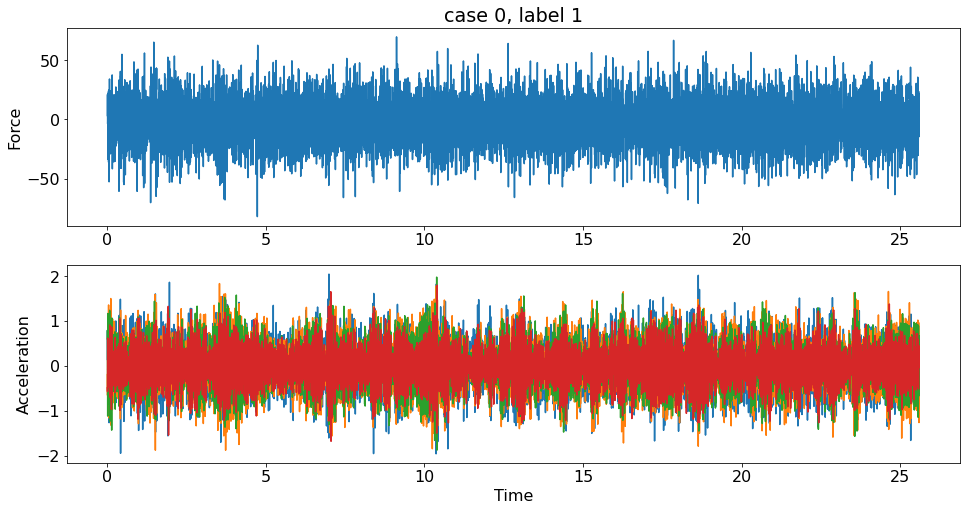

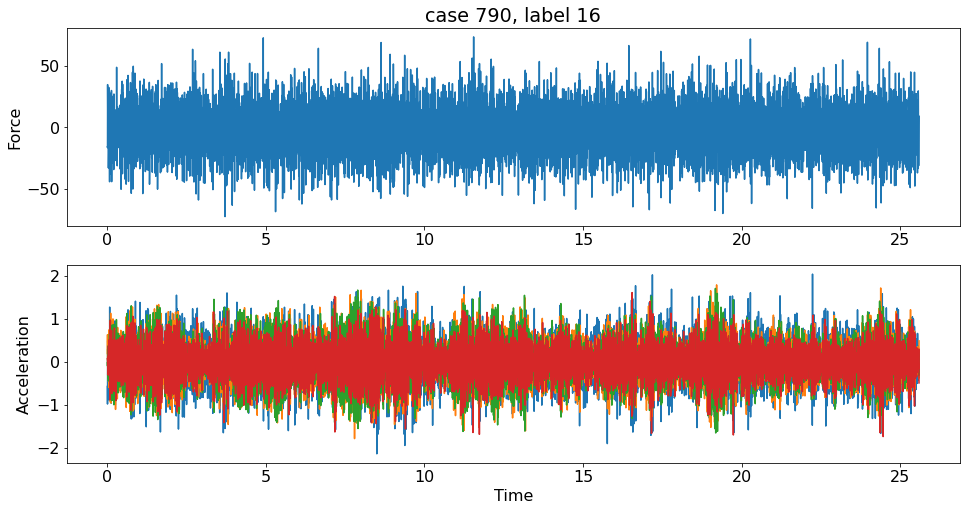

In [4]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time_vec = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time_vec,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time_vec,Ch2[:,case],time_vec,Ch3[:,case],time_vec,Ch4[:,case],time_vec,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

## Ajustando modelos AR-X

In [5]:
t_ini = time.time()

lag = 29 # escolhido o 29 para que a matriz X1 tenha o formato 850x120
canais = [Ch2, Ch3, Ch4, Ch5]

X1 = []

for amostra in range(850): # loop sobre as amostras medidas (series temporais)
    
    parametros = []
    
    for canal in canais: # loop sobre os 4 canais de interesse
        
        ajuste = AutoReg(canal[:,amostra],lags=lag).fit()
        parametros.append(ajuste.params) # montando cada uma das 850 linhas da matriz
        
    X1.append(np.hstack(parametros)) # inserindo a linha na matriz

X1 = np.array(X1)

t_final = time.time()

print('Processo de ajuste dos modelos AR demorou {:.2f} segundos.'.format((t_final - t_ini)))

print('Formato da matriz X1: {}'.format(X1.shape))

Processo de ajuste dos modelos AR demorou 38.43 segundos.
Formato da matriz X1: (850, 120)


## Aplicando o PCA

Text(0, 0.5, 'Percentual da Variância Explicada (%)')

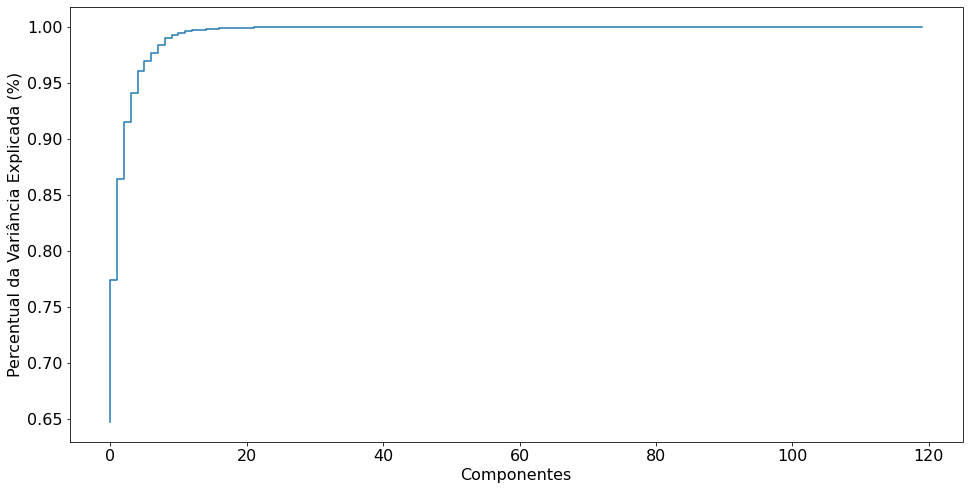

In [6]:
# Grafico que informa quanto da variancia e explicada utilizando X componentes

pca_full = PCA().fit(X1)

var_exp = pca_full.explained_variance_ratio_
var_cumu = np.cumsum(var_exp)

plt.step(range(0,len(var_cumu)),var_cumu)

plt.xlabel('Componentes')
plt.ylabel('Percentual da Variância Explicada (%)')


O gráfico acima mostra que grande parte das informações presente nos dados medidos pode ser bem representada com um número muito menor de componentes. Por exemplo, a curva se aproxima bastante de 100% a partir de 25 componentes.

Porcentagem da variancia explicada por cada componente:
Componente 1: 64.70%
Componente 2: 12.65%
Componente 3: 9.02%
Componente 4: 5.11%
Componente 5: 2.62%
Componente 6: 1.95%
Componente 7: 0.86%
Componente 8: 0.75%
Componente 9: 0.73%


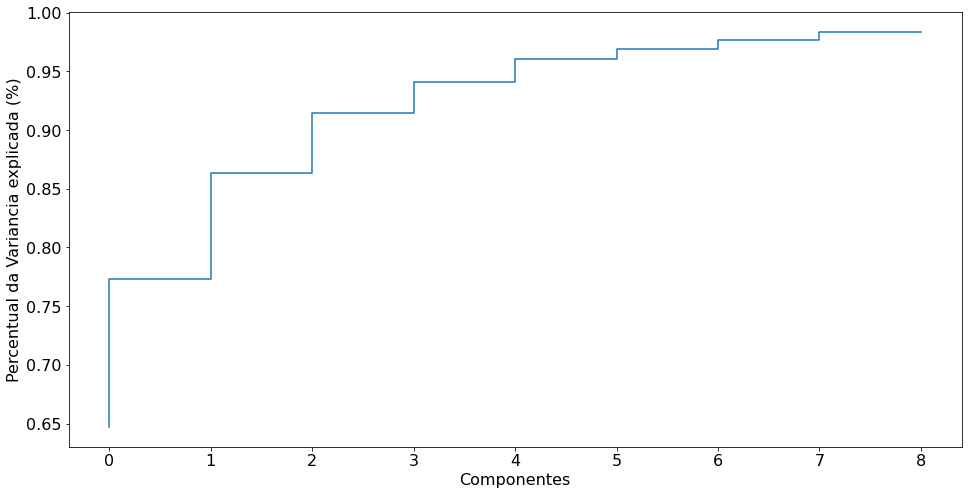

In [7]:
meta_variancia_exp = 0.98

pca = PCA(n_components = meta_variancia_exp, svd_solver = 'full').fit(X1)

var_exp = pca.explained_variance_ratio_
var_cumu = np.cumsum(var_exp)

plt.step(range(0,len(var_cumu)),var_cumu)

plt.xlabel('Componentes')
plt.ylabel('Percentual da Variancia explicada (%)')

print('Porcentagem da variancia explicada por cada componente:')
for i in range(len(var_exp)):
    print('Componente {}: {:.2f}%'.format(i+1, var_exp[i]*100))

X2 = pca.transform(X1)

Para garantir que 98% da variância consiga ser bem representada, basta utilizar 9 componentes, em que a capacidade que cada um tem para representar a variância nos dados está apresentada na célula acima.

## Normalizando as features

In [8]:
scaler = MinMaxScaler(feature_range=(-1,1))

X1_scaled = scaler.fit(X1).transform(X1)

X2_scaled = scaler.fit(X2).transform(X2)

## Visualizando e Comparando X1 e X2

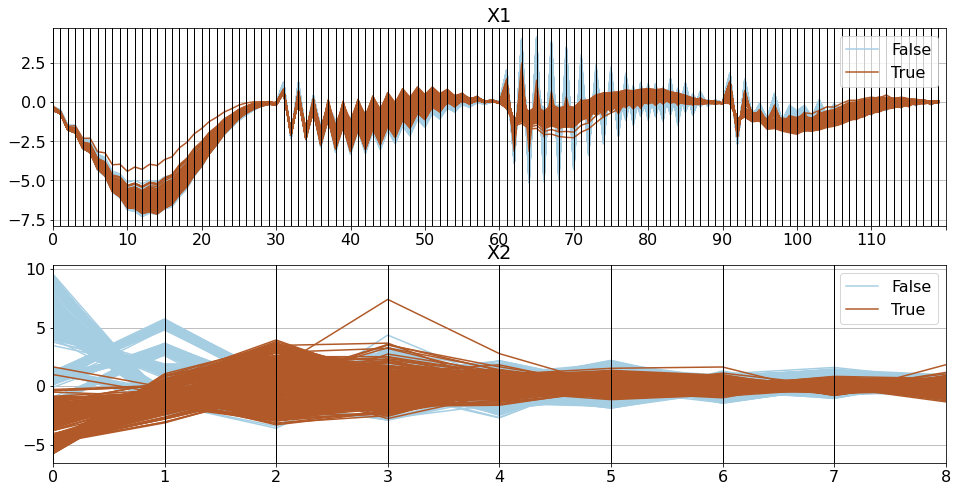

In [9]:
indDam = y > 9

dfX1 = pd.concat([pd.DataFrame(X1),pd.DataFrame({'target':indDam})],axis=1)
dfX2 = pd.concat([pd.DataFrame(X2),pd.DataFrame({'target':indDam})],axis=1)

fig = plt.figure()
ax1 = fig.add_subplot(211)
pd.plotting.parallel_coordinates(dfX1,'target',colormap=plt.get_cmap('Paired'))
ax1.title.set_text('X1')
plt.xticks(np.arange(0, 121, 10))


ax2 = fig.add_subplot(212)
pd.plotting.parallel_coordinates(dfX2,'target',colormap=plt.get_cmap('Paired'))
ax2.title.set_text('X2')

## Visualizando X1 e X2 normalizados

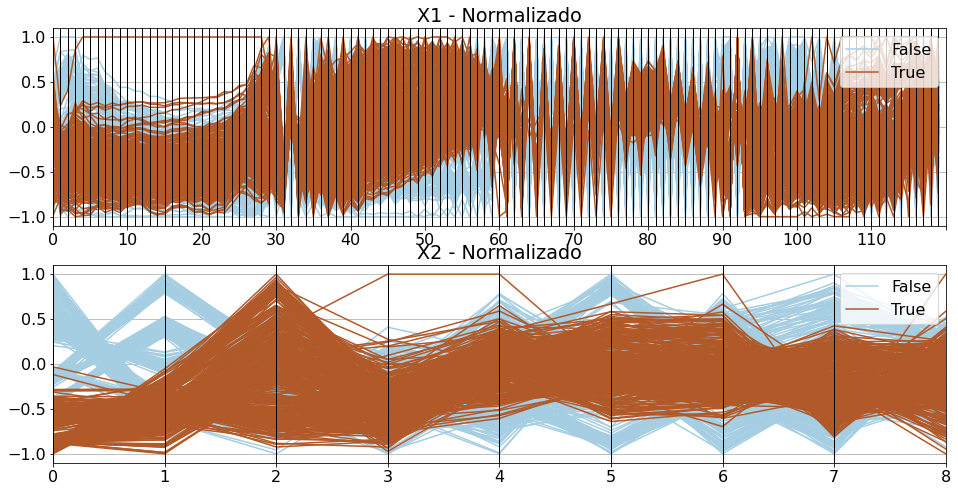

In [10]:
indDam = y > 9

dfX1_scaled = pd.concat([pd.DataFrame(X1_scaled),pd.DataFrame({'target':indDam})],axis=1)
dfX2_scaled = pd.concat([pd.DataFrame(X2_scaled),pd.DataFrame({'target':indDam})],axis=1)

fig = plt.figure()
ax1 = fig.add_subplot(211)
pd.plotting.parallel_coordinates(dfX1_scaled,'target',colormap=plt.get_cmap('Paired'))
ax1.title.set_text('X1 - Normalizado')
plt.xticks(np.arange(0, 121, 10))


ax2 = fig.add_subplot(212)
pd.plotting.parallel_coordinates(dfX2_scaled,'target',colormap=plt.get_cmap('Paired'))
ax2.title.set_text('X2 - Normalizado')

# Desempenho com hiperparâmetros default

In [13]:
class Resultados_model:
    def __init__(self, score_train, score_test, cm_test):
        self.score_train = score_train
        self.score_test = score_test
        self.cm = cm_test
        
    def save_param(self, dic):
        self.param = dic
        
    def print_param(self):
        for param in self.param.keys():
            if isinstance(self.param[param], np.floating):
                print('  {} = {:.2f}'.format(param, self.param[param]))
            else:            
                print('  {} = {}'.format(param, self.param[param]))
                
        print('')
                
    def print_resultados(self):
        print('# Resultados:')
        print('  Train score = {:.4f}'.format(self.score_train))
        print('  Test score = {:.4f}'.format(self.score_test))
        print('')
        

In [14]:
# criando as variáveis que serão usadas em todo o processo
rand_seed = 314

X2_tr, X2_te, y_tr, y_te = train_test_split(X2, y, random_state = rand_seed, test_size = 0.3)

## Modelo KMeans

### Ajustando o modelo e reclassificando a resposta prevista

In [15]:
# ajustando o modelo
KMeans_X2 = KMeans(n_clusters = 17, random_state = 72).fit(X2_tr)

# realizando a previsao do modelo para os dados de treinamento
y_KMeans_pred = KMeans_X2.fit_predict(X2_tr)

# associando as labels previstos com os labels dos experimentos
y_KMeans_pred_labeled = np.zeros(y_KMeans_pred.shape)
for i in range(17):
    mask = (y_KMeans_pred == i)
    label = mode(y_tr[mask])[0][0]
    y_KMeans_pred_labeled = np.where(mask, label, y_KMeans_pred_labeled)

### Plotando os clusters

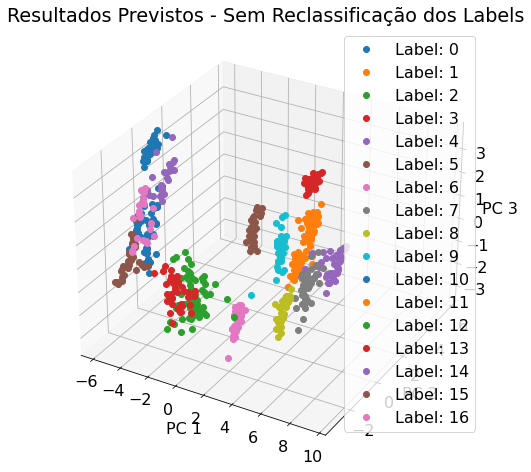

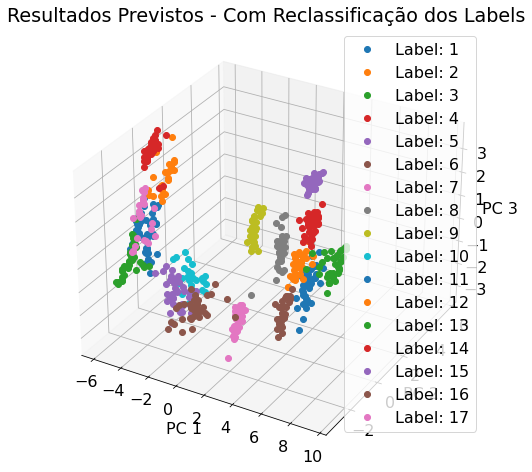

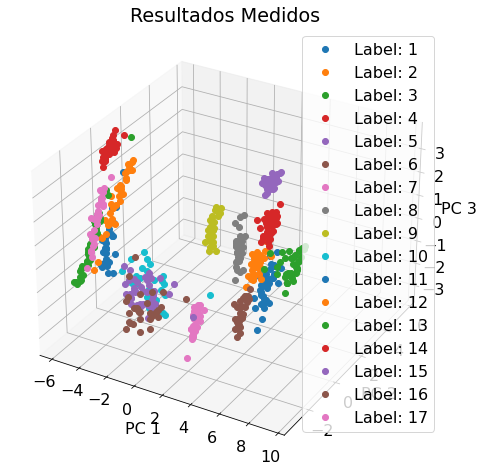

In [16]:
# plotando os resultados previstos - sem reclassificacao labels
fig = plt.figure()
ax = plt.axes(projection ='3d')

for i in range(17):
    X2_tr_i = X2_tr[y_KMeans_pred == i]
    ax.plot3D(X2_tr_i[:,0], X2_tr_i[:,1], X2_tr_i[:,2], 'o', label='Label: {}'.format(i))
    
ax.set_title("Resultados Previstos - Sem Reclassificação dos Labels")
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.legend()

# plotando os resultados previstos - com reclassificacao labels
fig2 = plt.figure()
ax2 = plt.axes(projection ='3d')

for i in range(1,17+1):
    X2_tr_i = X2_tr[y_KMeans_pred_labeled == i]
    ax2.plot3D(X2_tr_i[:,0], X2_tr_i[:,1], X2_tr_i[:,2], 'o', label='Label: {}'.format(i))
    
ax2.set_title("Resultados Previstos - Com Reclassificação dos Labels")
ax2.set_xlabel('PC 1')
ax2.set_ylabel('PC 2')
ax2.set_zlabel('PC 3')
ax2.legend()

# plotando os dados medidos
fig3 = plt.figure()
ax3 = plt.axes(projection ='3d')

for i in range(1,17+1):
    X2_tr_i = X2_tr[y_tr == i]
    ax3.plot3D(X2_tr_i[:,0], X2_tr_i[:,1], X2_tr_i[:,2], 'o', label='Label: {}'.format(i))
    
ax3.set_title("Resultados Medidos")
ax3.set_xlabel('PC 1')
ax3.set_ylabel('PC 2')
ax3.set_zlabel('PC 3')
ax3.legend()

### Plotando a matriz de confusão

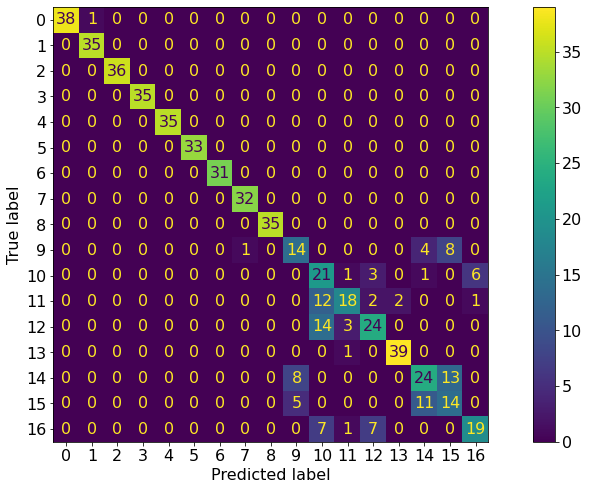

In [17]:
# Plotando a matriz de confusao
cm_test = confusion_matrix(y_tr, y_KMeans_pred_labeled)
ConfusionMatrixDisplay(cm_test).plot()

### Visualizando os resultados com t-SNE

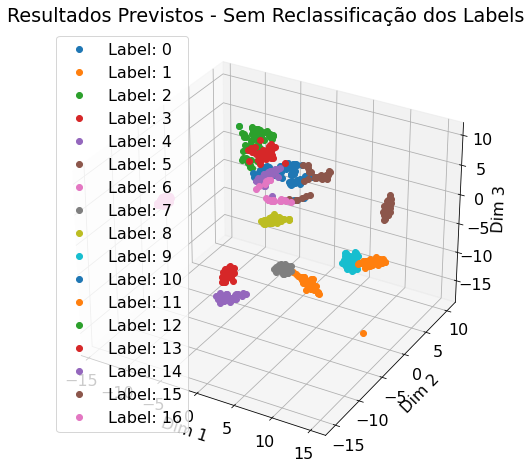

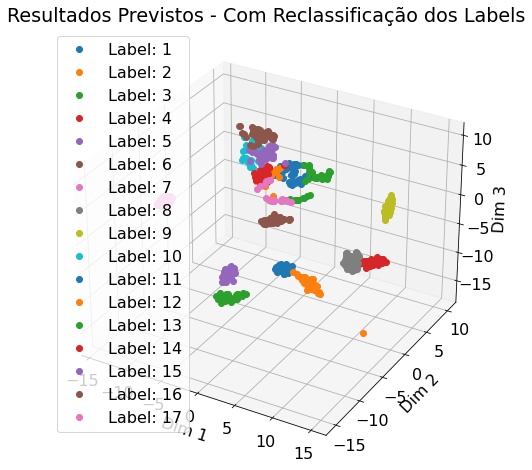

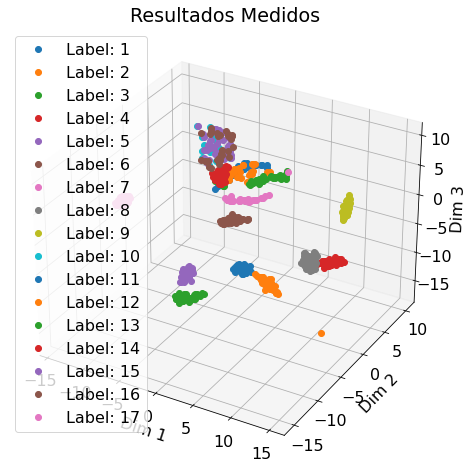

In [18]:
tsne = TSNE(n_components=3)

X2_tr_tsne = TSNE(n_components=3).fit_transform(X2_tr)

# plotando os resultados previstos - sem reclassificacao labels
fig = plt.figure()
ax = plt.axes(projection ='3d')

for i in range(17):
    X2_tr_i = X2_tr_tsne[y_KMeans_pred == i]
    ax.plot3D(X2_tr_i[:,0], X2_tr_i[:,1], X2_tr_i[:,2], 'o', label='Label: {}'.format(i))
    
ax.set_title("Resultados Previstos - Sem Reclassificação dos Labels")
ax.set_xlabel('Dim 1')
ax.set_ylabel('Dim 2')
ax.set_zlabel('Dim 3')
ax.legend()

# plotando os resultados previstos - com reclassificacao labels
fig2 = plt.figure()
ax2 = plt.axes(projection ='3d')

for i in range(1,17+1):
    X2_tr_i = X2_tr_tsne[y_KMeans_pred_labeled == i]
    ax2.plot3D(X2_tr_i[:,0], X2_tr_i[:,1], X2_tr_i[:,2], 'o', label='Label: {}'.format(i))
    
ax2.set_title("Resultados Previstos - Com Reclassificação dos Labels")
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_zlabel('Dim 3')
ax2.legend()

# plotando os dados medidos
fig3 = plt.figure()
ax3 = plt.axes(projection ='3d')

for i in range(1,17+1):
    X2_tr_i = X2_tr_tsne[y_tr == i]
    ax3.plot3D(X2_tr_i[:,0], X2_tr_i[:,1], X2_tr_i[:,2], 'o', label='Label: {}'.format(i))
    
ax3.set_title("Resultados Medidos")
ax3.set_xlabel('Dim 1')
ax3.set_ylabel('Dim 2')
ax3.set_zlabel('Dim 3')
ax3.legend()

## Modelo OneClassSVM

In [19]:
# ajustando o modelo
OneClassSVM_X2 = OneClassSVM(kernel='poly').fit(X2_tr)

# realizando a previsao do modelo para os dados de treinamento
y_OneClassSVM_pred = OneClassSVM_X2.predict(X2_tr)

# reclassificando os dados de treinamento (0 = nominal, 1 = falha)
y_tr_falha_relabeled = np.where(y_tr <= 9, 1, 0)

# reclassificando a resposta prevista (0 = nominal, 1 = falha)
y_OneClassSVM_pred_labeled = np.zeros(y_OneClassSVM_pred.shape)
for i in [-1, 1]:
    mask = (y_OneClassSVM_pred == i)
    label = mode(y_tr_falha_relabeled[mask])[0][0]
    y_OneClassSVM_pred_labeled = np.where(mask, label, y_OneClassSVM_pred_labeled)

### Plotando os clusters

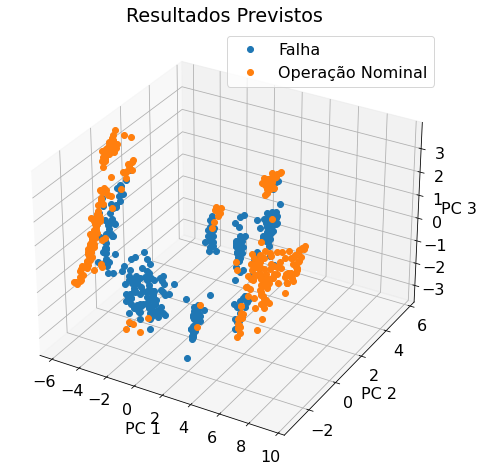

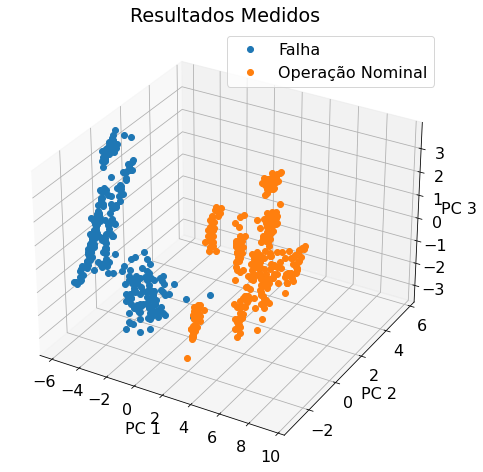

In [20]:
# plotando os resultados previstos
fig = plt.figure()
ax = plt.axes(projection ='3d')

for i in range(2):    
    if i == 0:
        label = 'Falha'
    else:
        label = 'Operação Nominal'
    
    X2_tr_i = X2_tr[y_OneClassSVM_pred_labeled == i]
    ax.plot3D(X2_tr_i[:,0], X2_tr_i[:,1], X2_tr_i[:,2], 'o', label=label)
    
ax.set_title("Resultados Previstos")
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.legend()

# plotando os dados medidos
fig3 = plt.figure()
ax3 = plt.axes(projection ='3d')

for i in range(2):
    if i == 0:
        label = 'Falha'
    else:
        label = 'Operação Nominal'
        
    X2_tr_i = X2_tr[y_tr_falha_relabeled == i]
    ax3.plot3D(X2_tr_i[:,0], X2_tr_i[:,1], X2_tr_i[:,2], 'o', label=label)
    
ax3.set_title("Resultados Medidos")
ax3.set_xlabel('PC 1')
ax3.set_ylabel('PC 2')
ax3.set_zlabel('PC 3')
ax3.legend()

### Plotando a matriz de confusão

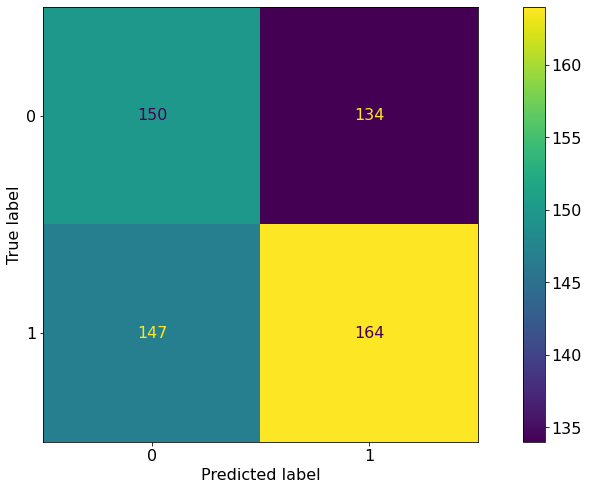

In [21]:
# Plotando a matriz de confusao
cm_test = confusion_matrix(y_tr_falha_relabeled, y_OneClassSVM_pred_labeled)
ConfusionMatrixDisplay(cm_test).plot()

# Conclusões

Como foi observado com os outros modelos estudados ao longo do curso, o modelo K-means não apresentou um bom desempenho para prever corretamente a extensão do dano, mas, observa-se na sua matriz de confusão, que ele tem um bom potencial preditivo para classificar entre falha e não falha, pois ele não prevê valores fora do range de classificação de dano (10 a 17) para os dados experimentais em que foi ensaiado um dano na estrutura.

Além disso, foi constatada a vantagem em se utilizar o t-SNE para a visualização de dados com muitas dimensões. Com ele, é possível observar a similaridade ou discrepância entre os dados com mais facilidade.

Quanto ao modelo de classificação OneClassSVM, nota-se que ele apresentou uma péssima capacidade preditiva para avaliar a presença ou não de dano na estrutura. Porém, não foi feito um estudo mais aprofundado para o ajuste dos hiperparêmetros de forma a melhorar o desempenho do modelo. Seria necessário realizar esse procedimento antes de copncluir pela incapacidade do método para essa previsão.